In [1]:
### libraries for data upload & wrangling

#!pip install -U kaleido
# !pip install folium
#!pip install psycopg2

import pandas as pd
import numpy as np 
import json
import calendar
import datetime as dt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from folium import plugins
from folium.plugins import MarkerCluster
#import psycopg2

### Load DF, feature inspection, and wrangling

In [2]:
# load the dataframe
df = pd.read_csv("https://raw.githubusercontent.com/DrakeData/raw_data_files/main/202209_divvy_distance_weather_v2.csv")

In [3]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,started_at_clean,duration,distance,started_at_unix,temp,hum,windsp,weather,rain,snow
0,2FD3F90EDCE2ACD9,classic_bike,9/1/2022 19:39,9/1/2022 19:46,Southport Ave & Roscoe St,13071,Broadway & Cornelia Ave,13278,41.943739,-87.664020,...,9/1/2022,481.9,1669.2,1662058800,89.89,38,8.05,Clouds,0.0,0
1,EE62794A94F80A83,classic_bike,9/1/2022 6:53,9/1/2022 7:02,LaSalle St & Washington St,13006,Wells St & Polk St,SL-011,41.882664,-87.632530,...,9/1/2022,395.0,1358.8,1662012000,73.96,71,6.91,Clear,0.0,0
2,56FD4B364747F270,electric_bike,9/1/2022 11:25,9/1/2022 11:28,N Sheffield Ave & W Wellington Ave,20256,Southport Ave & Wellington Ave,TA1307000006,41.940000,-87.650000,...,9/1/2022,411.5,1595.7,1662030000,69.58,78,5.75,Clear,0.0,0
3,BD4D6AC842CDF729,classic_bike,9/1/2022 7:46,9/1/2022 8:05,Racine Ave & Wrightwood Ave,TA1309000059,DuSable Lake Shore Dr & North Blvd,LF-005,41.928887,-87.658971,...,9/1/2022,948.8,3643.8,1662015600,73.54,72,6.91,Clear,0.0,0
4,2E0E8C378865C01A,electric_bike,9/1/2022 9:55,9/1/2022 10:12,Wabash Ave & Adams St,KA1503000015,Wood St & Taylor St (Temp),13285,41.879373,-87.625492,...,9/1/2022,1275.1,5104.7,1662022800,70.81,74,6.91,Clear,0.0,0


In [4]:
df.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
started_at_clean       object
duration              float64
distance              float64
started_at_unix         int64
temp                  float64
hum                     int64
windsp                float64
weather                object
rain                  float64
snow                    int64
dtype: object

In [6]:
#rename for predicted time from API call
df.rename(columns = {'duration':'pred_time'}, inplace = True)
print(df['pred_time'])

0          481.9
1          395.0
2          411.5
3          948.8
4         1275.1
           ...  
103880     670.3
103881     501.0
103882     241.5
103883     475.3
103884    1031.5
Name: pred_time, Length: 103885, dtype: float64


In [7]:
#look at how datetime is currently
df['started_at'].iloc[0]

'9/1/2022 19:39'

In [8]:
#convert to datetime type
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

In [9]:
#validate total_seconds works
(df['ended_at'].iloc[0] - df['started_at'].iloc[0]).total_seconds()

420.0

### wrangle and feature augmentation

In [10]:
#loop thru for seconds diff in actual ride time
result = []
for i in df.index: 
    result.append((df['ended_at'][i] - df['started_at'][i]).total_seconds())
    
df['actual_time'] = result

In [11]:
#loop thru for seconds diff between actual and predicted ride time
diff = []
for i in df.index:
    diff.append((df['actual_time'][i] - df['pred_time'][i]).round(2))
    
df['time_diff'] = diff

In [12]:
#clockwise quadrant creation starting from NW of Madison St & State St
quad = []
#for i in df.index:
for i in range(len(df)):
    if (df['start_lat'][i] >= 41.88206 and df['start_lng'][i] <= -87.62780):
        quad.append('A')
    elif (df['start_lat'][i] > 41.88206 and df['start_lng'][i] > -87.62780):
        quad.append('B')
    elif (df['start_lat'][i] < 41.88206 and df['start_lng'][i] > -87.62780):
        quad.append('C')
    elif (df['start_lat'][i] < 41.88206 and df['start_lng'][i] < -87.62780):
        quad.append('D')

### image
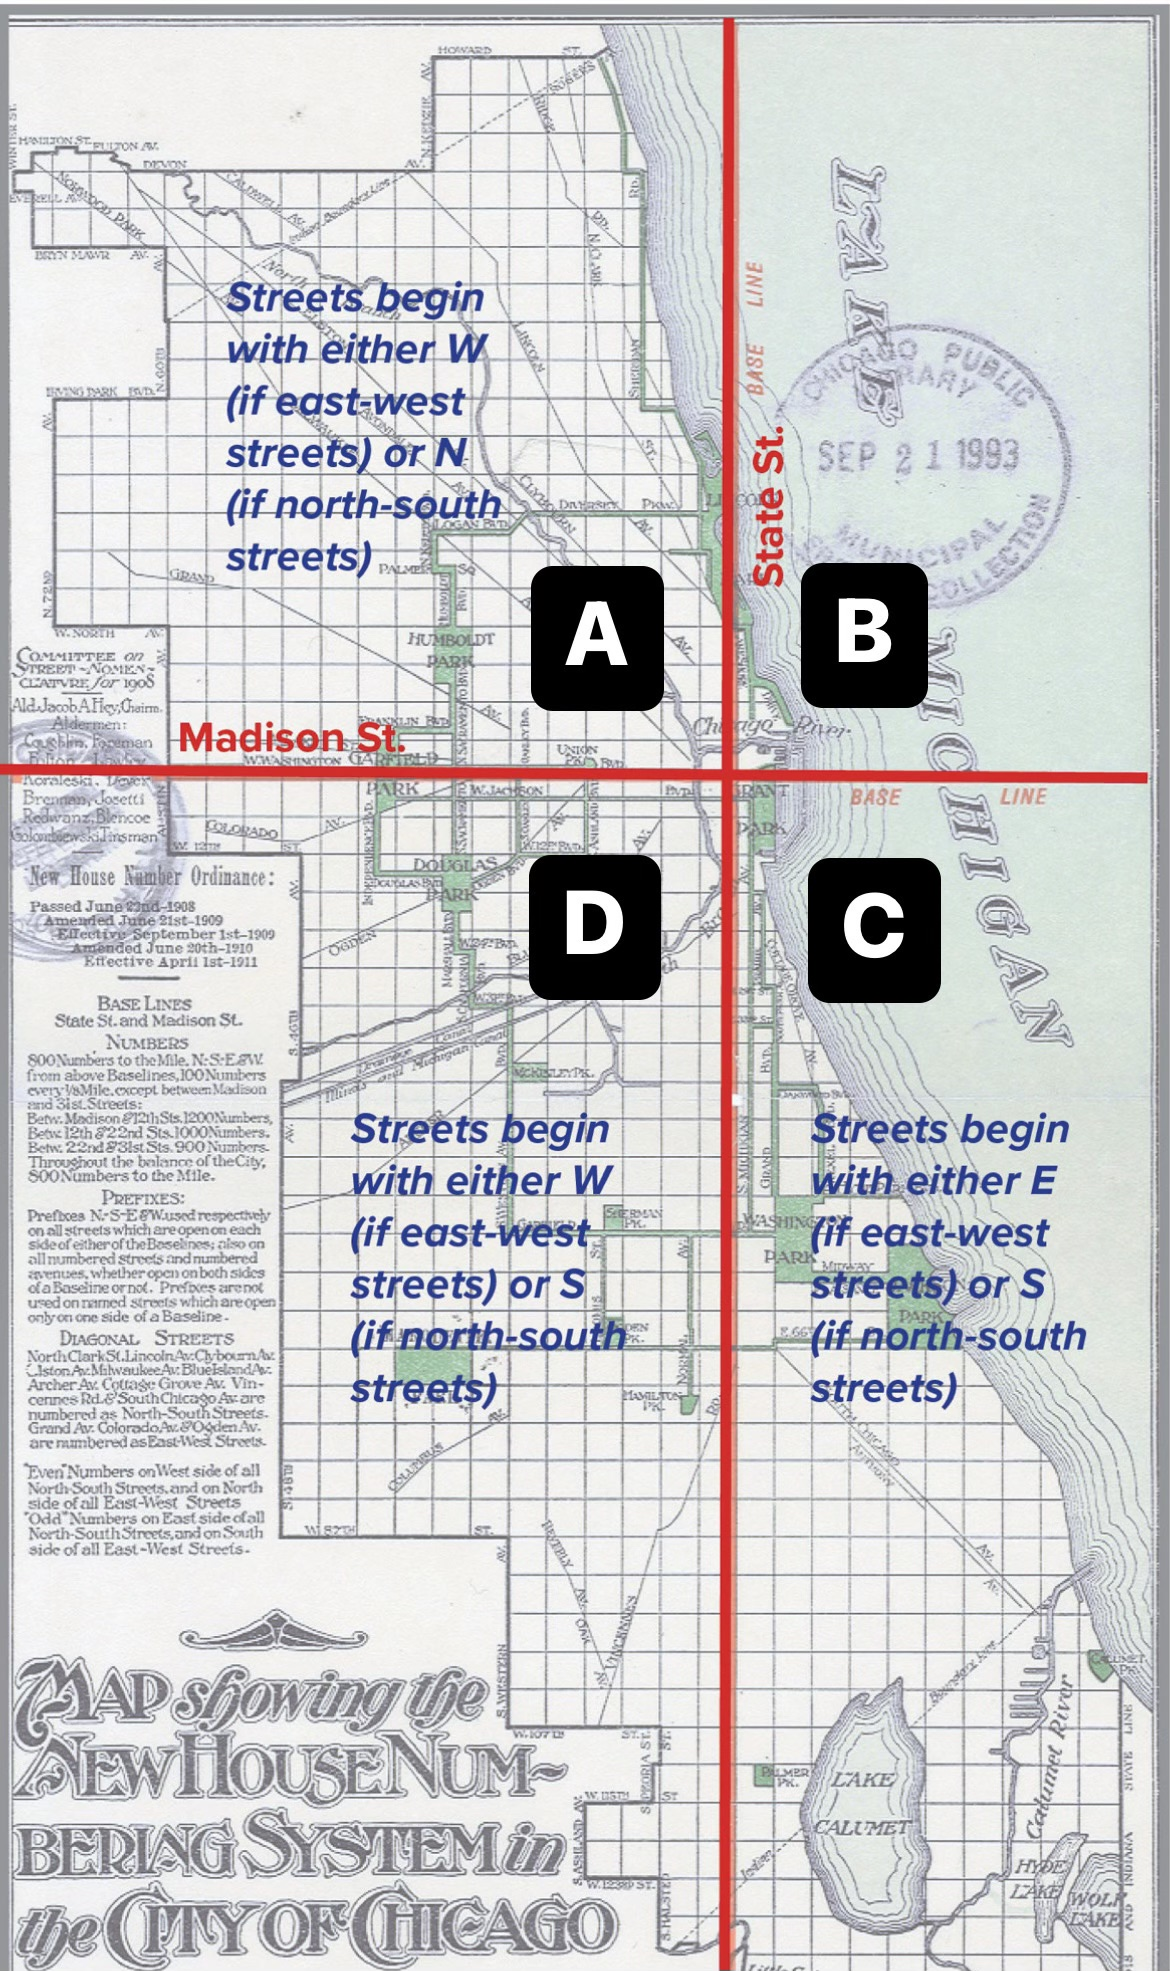

In [13]:
quad_set = set(quad)

print(len(quad))
print(len(quad_set))
print(quad)

103885
4
['A', 'A', 'A', 'A', 'C', 'A', 'C', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'D', 'A', 'D', 'C', 'A', 'A', 'D', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'D', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'C', 'A', 'A', 'B', 'A', 'D', 'A', 'A', 'C', 'A', 'C', 'A', 'C', 'A', 'C', 'A', 'A', 'A', 'A', 'A', 'A', 'D', 'D', 'A', 'A', 'A', 'A', 'B', 'A', 'C', 'D', 'A', 'A', 'C', 'A', 'A', 'A', 'B', 'C', 'A', 'A', 'A', 'D', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'A', 'A', 'B', 'A', 'A', 'A', 'D', 'C', 'C', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'D', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'D', 'A', 'A', 'A', 'B', 'B', 'B', 'D', 'A', 'A', 'A', 'A', 'C', 'D', 'D', 'A', 'A', 'A', 'A', 'A', 'A', 'D', 'A', 'A', 'A', 'D', 'A', 'A', 'D', 'A', 'D', 'A', 'A', 'A', 'D', 'D', 'D', 'C', 'A', 'A', 'A', 'A', 'A', 'A', 'D', 'A', 'A', 'A', 'D', 'D', 'A', 'A', 'A', 'A', 'D', 'A', 'D', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'B', 'C', 'A', 'A', 'C', 'A', 'A', 'A', 'A', 'D', 'A', 'D', 'A', 'A', 'D', 

In [14]:
df['quadrant']=quad

In [15]:
#get hour of ride start
start_hours = df['started_at'].dt.hour   
df['start_hour'] = start_hours

In [16]:
#get hour of ride end
end_hours = df['ended_at'].dt.hour
df['end_hour'] = end_hours

In [17]:
#double check
print('actual time:', df['actual_time'][0])
print('predicted time:', df['pred_time'][0])
print('time delta:', df['time_diff'][0])

actual time: 420.0
predicted time: 481.9
time delta: -61.9


In [18]:
#loop thru for day of week feature
result3 = []
for i in df.index:
    result3.append(df['started_at'][i].weekday())

df['day_of_week'] = result3

In [19]:
#convert numerical days to day names

#import calendar
#list(calendar.day_name)

print(calendar.day_abbr[df['day_of_week'][0]])

day_names = []

for i in df.index:
    day_names.append(calendar.day_abbr[df['day_of_week'][i]])
    
df['day_of_week_n'] = day_names

Thu


In [20]:
df.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,weather,rain,snow,actual_time,time_diff,quadrant,start_hour,end_hour,day_of_week,day_of_week_n
0,2FD3F90EDCE2ACD9,classic_bike,2022-09-01 19:39:00,2022-09-01 19:46:00,Southport Ave & Roscoe St,13071,Broadway & Cornelia Ave,13278,41.943739,-87.664020,...,Clouds,0.0,0,420.0,-61.9,A,19,19,3,Thu
1,EE62794A94F80A83,classic_bike,2022-09-01 06:53:00,2022-09-01 07:02:00,LaSalle St & Washington St,13006,Wells St & Polk St,SL-011,41.882664,-87.632530,...,Clear,0.0,0,540.0,145.0,A,6,7,3,Thu
2,56FD4B364747F270,electric_bike,2022-09-01 11:25:00,2022-09-01 11:28:00,N Sheffield Ave & W Wellington Ave,20256,Southport Ave & Wellington Ave,TA1307000006,41.940000,-87.650000,...,Clear,0.0,0,180.0,-231.5,A,11,11,3,Thu
3,BD4D6AC842CDF729,classic_bike,2022-09-01 07:46:00,2022-09-01 08:05:00,Racine Ave & Wrightwood Ave,TA1309000059,DuSable Lake Shore Dr & North Blvd,LF-005,41.928887,-87.658971,...,Clear,0.0,0,1140.0,191.2,A,7,8,3,Thu
4,2E0E8C378865C01A,electric_bike,2022-09-01 09:55:00,2022-09-01 10:12:00,Wabash Ave & Adams St,KA1503000015,Wood St & Taylor St (Temp),13285,41.879373,-87.625492,...,Clear,0.0,0,1020.0,-255.1,C,9,10,3,Thu


### EDA for human flow

In [21]:
#time range
print('time diff max:', df['time_diff'].max())
print('time diff min:', df['time_diff'].min())

time diff max: 77880.0
time diff min: -2097.6


member    59550
casual    44335
Name: member_casual, dtype: int64


<BarContainer object of 2 artists>

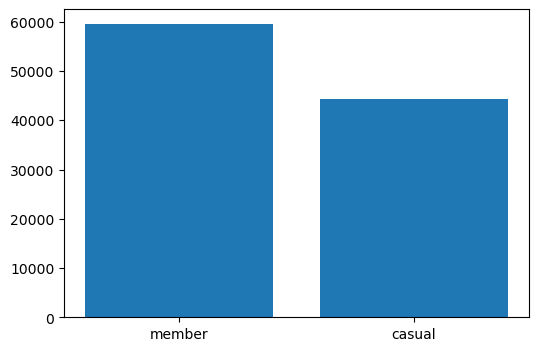

In [22]:
#membership distribution
mem_dist = df['member_casual'].value_counts()
print(mem_dist)
fig, ax = plt.subplots(figsize=(6,4))
plt.bar(('member', 'casual'), mem_dist)
#sns.despine(fig)

### popular stations

In [23]:
#filter down to just elements for popular stations
popular_stations = df[["ride_id", "start_station_name", "end_station_name", 'quadrant']]
print(list(popular_stations))

['ride_id', 'start_station_name', 'end_station_name', 'quadrant']


In [24]:
#Getting count of popular start stations
pop_start_stations = popular_stations.groupby("start_station_name").size().reset_index(name='counts')

#sort by count, top 10
pop_start_stations.sort_values(by=['counts'], ascending=False)[0:20]

pop_start = pop_start_stations.sort_values(by=['counts'], ascending=False)[0:10]

In [25]:
#Getting count of popular start stations
pop_end_stations = popular_stations.groupby("end_station_name").size().reset_index(name='counts')

#sort by count, top 10
pop_end_stations.sort_values(by=['counts'], ascending=False)[0:20]

,end_station_name,counts
848,Streeter Dr & Grand Ave,1778
515,Michigan Ave & Oak St,971
243,DuSable Lake Shore Dr & North Blvd,942
242,DuSable Lake Shore Dr & Monroe St,879
522,Millennium Park,860
896,Wells St & Concord Ln,826
151,Clark St & Elm St,761
60,Broadway & Barry Ave,748
851,Theater on the Lake,705
403,Kingsbury St & Kinzie St,638


In [26]:
#popular trips with no loops
routes = (df.groupby(["start_station_name", "end_station_name"]).size().sort_values(ascending=False).reset_index(name='count').drop_duplicates(subset="end_station_name"))
routes.reset_index(drop=True)

,start_station_name,end_station_name,count
0,Streeter Dr & Grand Ave,Streeter Dr & Grand Ave,279
1,DuSable Lake Shore Dr & Monroe St,DuSable Lake Shore Dr & Monroe St,162
2,Morgan St & Polk St,Loomis St & Lexington St,147
3,State St & 33rd St,Calumet Ave & 33rd St,134
4,Loomis St & Lexington St,Morgan St & Polk St,131
...,...,...,...
951,Maplewood Ave & Peterson Ave,Public Rack - Sawyer Ave & Bryn Mawr Ave - SW,1
952,Menard Ave & Division St,Menard Ave & Division St,1
953,Logan Blvd & Elston Ave,Public Rack - St Louis Ave & Berteau Ave,1
954,Long Ave & Belmont Ave,Public Rack - Central Ave & George St,1


In [27]:
#popular trips by start/end and day of week
route_dow = (df.groupby(["start_station_name", "end_station_name", 'day_of_week_n']).size().sort_values(ascending=False).reset_index(name='count').drop_duplicates(subset="end_station_name"))
route_dow.reset_index(drop=True)

,start_station_name,end_station_name,day_of_week_n,count
0,Streeter Dr & Grand Ave,Streeter Dr & Grand Ave,Sat,72
1,DuSable Lake Shore Dr & Monroe St,DuSable Lake Shore Dr & Monroe St,Sat,47
2,Morgan St & Polk St,Loomis St & Lexington St,Tue,39
3,State St & 33rd St,Calumet Ave & 33rd St,Tue,34
4,Loomis St & Lexington St,Morgan St & Polk St,Tue,31
...,...,...,...,...
951,Phillips Ave & 79th St,Commercial Ave & 83rd St,Sun,1
952,Perry Ave & 69th St,Eggleston Ave & 69th St,Thu,1
953,Michigan Ave & Madison St,Racine Ave & 65th St,Sat,1
954,Menard Ave & Division St,Menard Ave & Division St,Fri,1


In [28]:
#popular trips by day of week and membership
route_dow_mem = (df.groupby(["start_station_name", "end_station_name", 'day_of_week_n', 'member_casual']).size().sort_values(ascending=False).reset_index(name='count').drop_duplicates(subset="end_station_name"))
route_dow_mem.reset_index(drop=True)


,start_station_name,end_station_name,day_of_week_n,member_casual,count
0,Streeter Dr & Grand Ave,Streeter Dr & Grand Ave,Sat,casual,71
1,DuSable Lake Shore Dr & Monroe St,DuSable Lake Shore Dr & Monroe St,Sat,casual,44
2,State St & 33rd St,Calumet Ave & 33rd St,Tue,member,32
3,Morgan St & Polk St,Loomis St & Lexington St,Tue,member,32
4,Loomis St & Lexington St,Morgan St & Polk St,Tue,member,29
...,...,...,...,...,...
951,Millard Ave & 26th St,Tripp Ave & 31st St,Fri,casual,1
952,Michigan Ave & Madison St,Racine Ave & 65th St,Sat,casual,1
953,Nagle Ave & Belmont Ave,Nagle Ave & Belmont Ave,Thu,casual,1
954,Narragansett & Irving Park,Mulligan Ave & Wellington Ave,Tue,member,1


### start hour analytics

In [29]:
#popular trips by start/end and day of week and start hour
route_dow_h = (df.groupby(["start_station_name", "end_station_name", 'day_of_week_n', 'start_hour']).size().sort_values(ascending=False).reset_index(name='count').drop_duplicates(subset="end_station_name"))
route_dow_h.reset_index(drop=True)


,start_station_name,end_station_name,day_of_week_n,start_hour,count
0,Streeter Dr & Grand Ave,Streeter Dr & Grand Ave,Sat,16,12
1,DuSable Lake Shore Dr & Monroe St,DuSable Lake Shore Dr & Monroe St,Sun,18,10
2,Indiana Ave & Roosevelt Rd,Wabash Ave & Grand Ave,Sun,15,8
3,Millennium Park,Millennium Park,Mon,17,8
4,Loomis St & Lexington St,Morgan St & Polk St,Tue,17,6
...,...,...,...,...,...
951,Parkside Ave & Armitage Ave,Public Rack - N Narragansett Ave & Grand Ave,Wed,16,1
952,Narragansett & Wrightwood,Narragansett Ave & School St,Thu,12,1
953,Nagle Ave & Belmont Ave,Nagle Ave & Belmont Ave,Thu,18,1
954,Narragansett & Irving Park,Mulligan Ave & Wellington Ave,Tue,17,1


In [30]:
#popular trips by start/end and day of week, start hour, mem
route_dow_h_mem = (df.groupby(["start_station_name", "end_station_name", 'day_of_week_n', 'start_hour', 'member_casual']).size().sort_values(ascending=False).reset_index(name='count').drop_duplicates(subset="end_station_name"))
route_dow_h_mem.reset_index(drop=True)

top100start = route_dow_h_mem[0:100]
top100start

,start_station_name,end_station_name,day_of_week_n,start_hour,member_casual,count
0,Streeter Dr & Grand Ave,Streeter Dr & Grand Ave,Sat,16,casual,12
2,DuSable Lake Shore Dr & Monroe St,DuSable Lake Shore Dr & Monroe St,Sun,18,casual,10
6,Indiana Ave & Roosevelt Rd,Wabash Ave & Grand Ave,Sun,15,casual,8
9,Millennium Park,Millennium Park,Mon,17,casual,7
15,Loomis St & Lexington St,Morgan St & Polk St,Thu,16,member,6
...,...,...,...,...,...,...
312,DuSable Lake Shore Dr & Diversey Pkwy,Franklin St & Chicago Ave,Fri,22,casual,3
315,Benson Ave & Church St,Evanston Civic Center,Sun,14,casual,3
317,Spaulding Ave & Armitage Ave,Kedzie Ave & Milwaukee Ave,Sun,21,casual,3
318,Larrabee St & Oak St,Wilton Ave & Diversey Pkwy*,Wed,21,casual,3


In [31]:
#popular trips by start and day of week
start_route_dow = (df.groupby(['start_station_name', 'day_of_week_n']).size().sort_values(ascending=False).reset_index(name='count').drop_duplicates(subset="start_station_name"))
start_route_dow.reset_index(drop=True)

,start_station_name,day_of_week_n,count
0,Streeter Dr & Grand Ave,Sat,403
1,DuSable Lake Shore Dr & North Blvd,Sat,222
2,DuSable Lake Shore Dr & Monroe St,Sat,216
3,Millennium Park,Sat,187
4,Michigan Ave & Oak St,Sat,183
...,...,...,...
926,Public Rack - Champlain Ave & 65th St,Tue,1
927,Public Rack - Chopin Park,Sun,1
928,Public Rack - Christiana Ave & Bryn Mawr Ave,Mon,1
929,Public Rack - Cicero Ave & Altgeld St,Sun,1


In [32]:
start_route_h = (df.groupby(['start_station_name', 'start_hour']).size().sort_values(ascending=False).reset_index(name='count'))
start_route_h.reset_index(drop=True)

start_route_h_20 = start_route_h[0:20]
start_route_h_20

,start_station_name,start_hour,count
0,Streeter Dr & Grand Ave,17,205
1,Streeter Dr & Grand Ave,16,202
2,Streeter Dr & Grand Ave,14,191
3,Streeter Dr & Grand Ave,15,191
4,Streeter Dr & Grand Ave,18,150
5,Streeter Dr & Grand Ave,19,135
6,Streeter Dr & Grand Ave,13,134
7,Streeter Dr & Grand Ave,12,120
8,Clinton St & Washington Blvd,17,119
9,Canal St & Adams St,17,111


In [33]:
route_start_dow_h = (df.groupby(['start_station_name', 'day_of_week_n', 'start_hour']).size().sort_values(ascending=False).reset_index(name='count'))
route_start_dow_h.reset_index(drop=True)

,start_station_name,day_of_week_n,start_hour,count
0,Streeter Dr & Grand Ave,Sat,14,53
1,Streeter Dr & Grand Ave,Sat,16,50
2,Streeter Dr & Grand Ave,Sat,15,50
3,Streeter Dr & Grand Ave,Sun,17,40
4,Streeter Dr & Grand Ave,Mon,15,39
...,...,...,...,...
40657,Lincoln Ave & Belle Plaine Ave,Sat,16,1
40658,Lincoln Ave & Belle Plaine Ave,Sat,17,1
40659,Lincoln Ave & Belle Plaine Ave,Sun,7,1
40660,Lincoln Ave & Belle Plaine Ave,Sun,8,1


### end hour analytics

In [34]:
#popular trips by end hour
route_dow_eh = (df.groupby(["start_station_name", "end_station_name", 'day_of_week_n', 'end_hour']).size().sort_values(ascending=False).reset_index(name='count').drop_duplicates(subset="end_station_name"))
route_dow_eh.reset_index(drop=True)


,start_station_name,end_station_name,day_of_week_n,end_hour,count
0,Streeter Dr & Grand Ave,Streeter Dr & Grand Ave,Sat,17,14
1,DuSable Lake Shore Dr & Monroe St,DuSable Lake Shore Dr & Monroe St,Sun,18,8
2,Streeter Dr & Grand Ave,Millennium Park,Mon,14,8
3,State St & 33rd St,Calumet Ave & 33rd St,Tue,13,8
4,Indiana Ave & Roosevelt Rd,Wabash Ave & Grand Ave,Sun,15,7
...,...,...,...,...,...
951,Parkside Ave & Armitage Ave,Public Rack - N Narragansett Ave & Grand Ave,Wed,16,1
952,Narragansett & Wrightwood,Narragansett Ave & School St,Thu,14,1
953,Narragansett & Irving Park,Mulligan Ave & Wellington Ave,Tue,17,1
954,Narragansett & Irving Park,Oak Park & Wellington,Tue,11,1


In [35]:
route_end_eh = (df.groupby(['end_station_name', 'end_hour']).size().sort_values(ascending=False).reset_index(name='count'))
route_end_eh.reset_index(drop=True)

,end_station_name,end_hour,count
0,Streeter Dr & Grand Ave,18,195
1,Streeter Dr & Grand Ave,15,192
2,Streeter Dr & Grand Ave,14,187
3,Streeter Dr & Grand Ave,17,183
4,Streeter Dr & Grand Ave,13,178
...,...,...,...
11471,Kilpatrick Ave & Parker Ave,21,1
11472,Kilpatrick Ave & Parker Ave,18,1
11473,Kilpatrick Ave & Parker Ave,12,1
11474,Kilpatrick Ave & Parker Ave,0,1


### station analytics

In [36]:
print('start station count:', df['start_station_name'].nunique())
print('end station count:', df['end_station_name'].nunique())

start station count: 931
end station count: 956


In [37]:
#how many trips started & ended at same station?
len((df.query('start_station_name == end_station_name'))) / len((df.query('start_station_name != end_station_name')))

0.07294829687467724

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

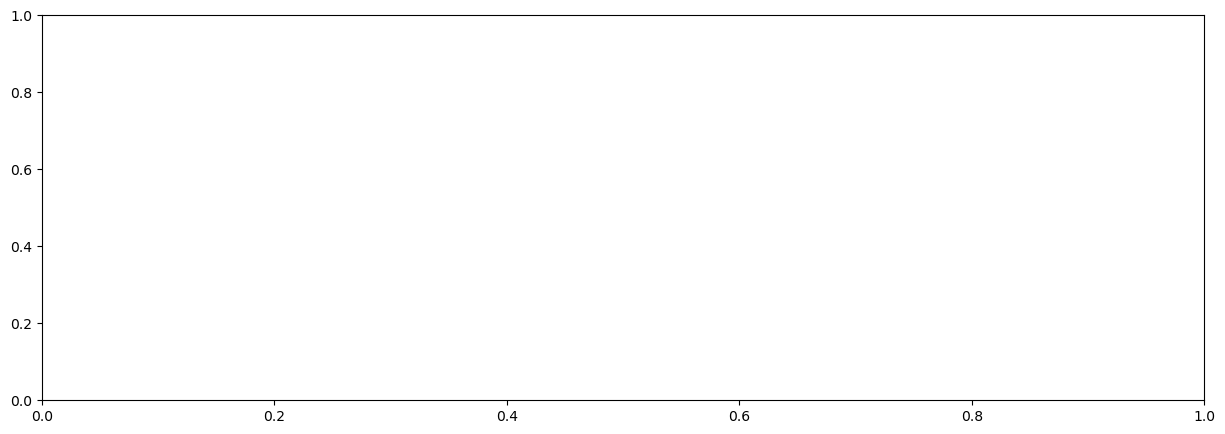

In [38]:
figure, ax = plt.subplots(figsize = (15,5))
sns.set_palette("Set1")
sns.scatterplot(x="start_lat", y="start_lng", size = 3,
            data=df, ax = ax).set_title('lat vs. long dist')

### time analytics

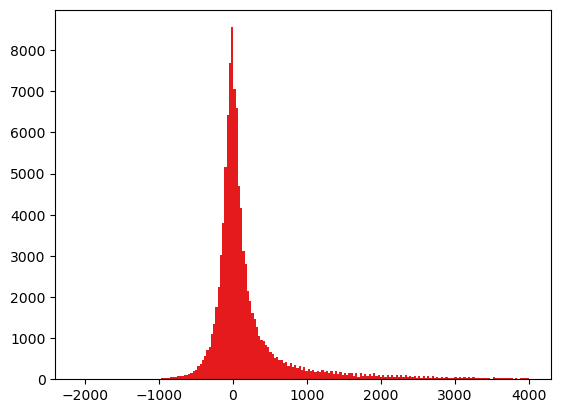

In [39]:
#general hist for time_diff
plt.hist(df['time_diff'], bins = 200, range=[-2100,4000])
plt.show()

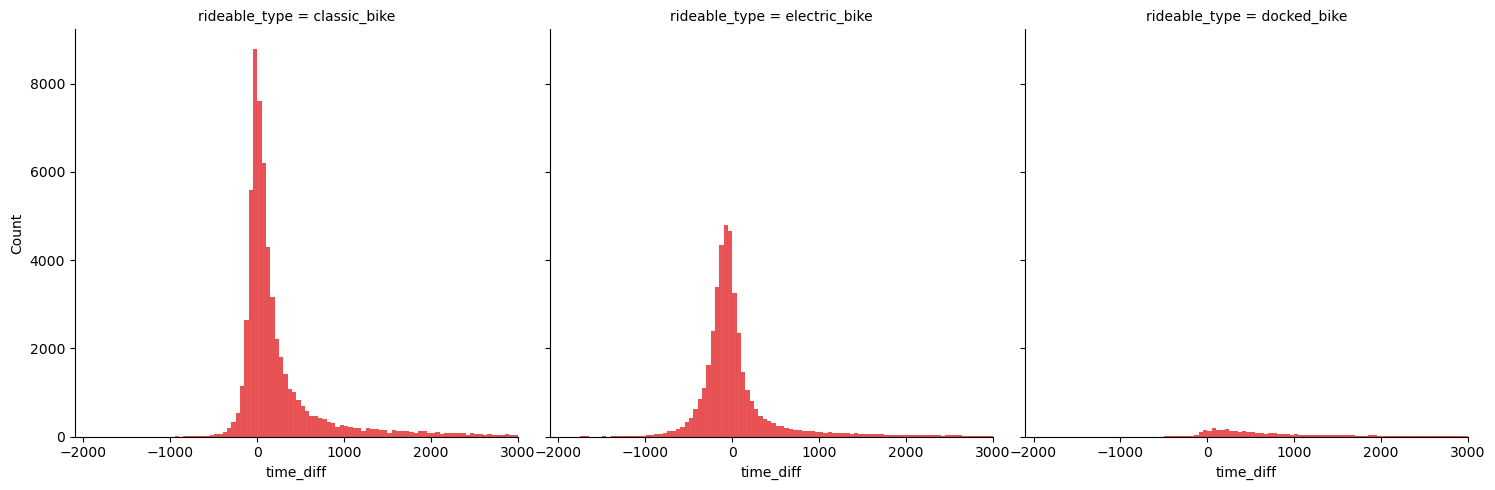

In [40]:
#distributed hist for ride types
ax = sns.displot(df, x='time_diff', col='rideable_type', binwidth=50)
ax.set(xlim=(-2100, 3000))

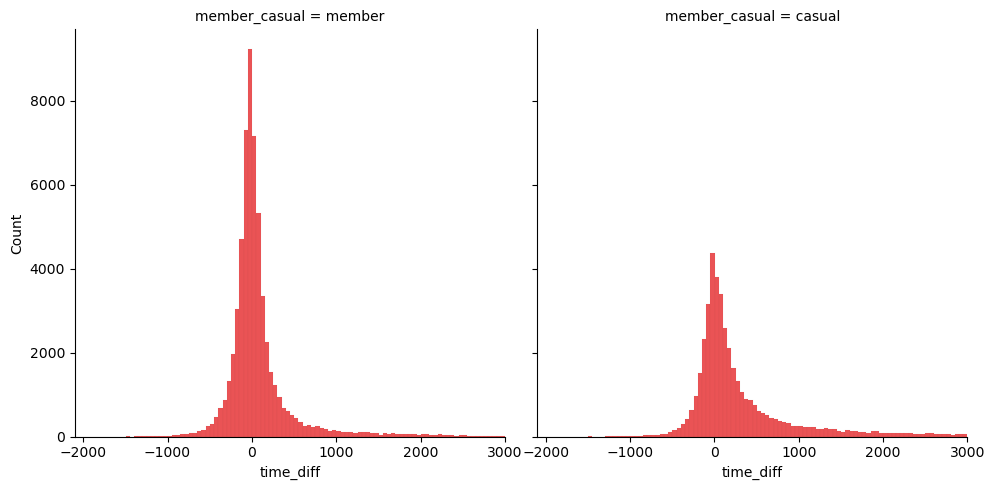

In [41]:
#distributed hist for members vs casual
ax = sns.displot(df, x='time_diff', col='member_casual', binwidth=50)
ax.set(xlim=(-2100, 3000))

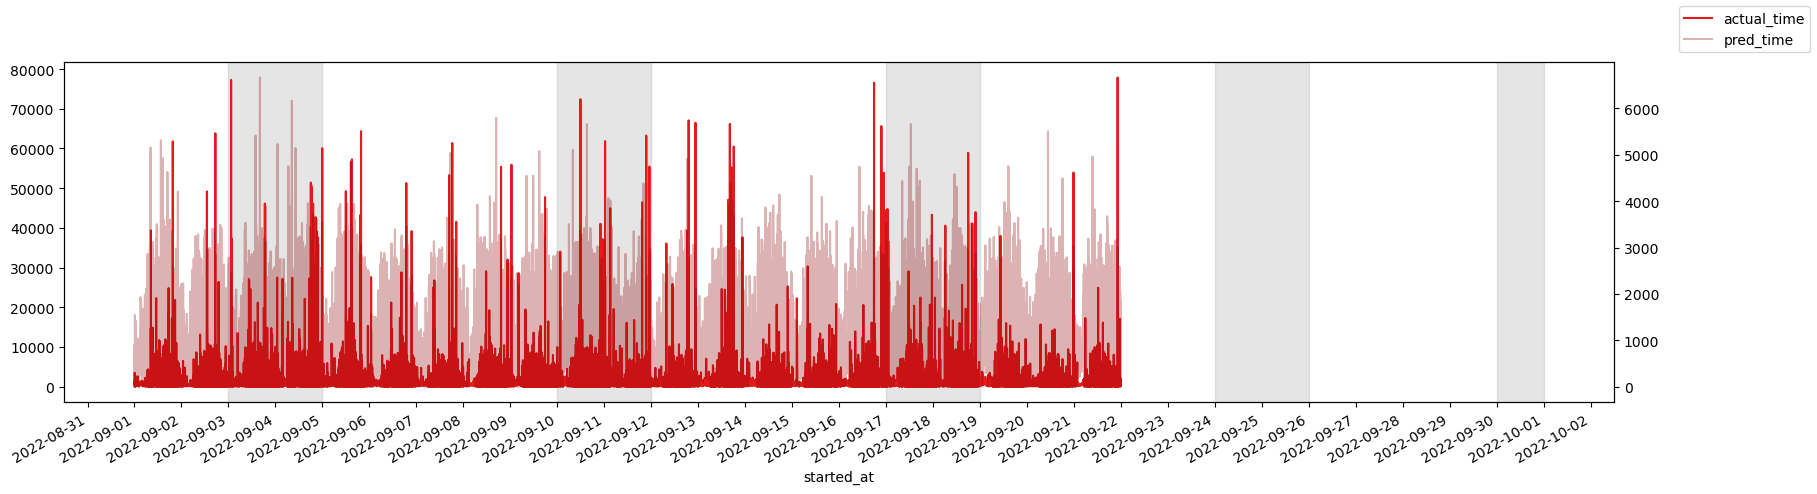

In [42]:
#looking for day variances

from matplotlib import dates

ax = df.plot(x="started_at", y="actual_time", legend=False, figsize=(20,5))
ax2 = ax.twinx()
df.plot(x="started_at", y="pred_time", ax=ax2, legend=False, color="darkred", alpha=0.3)
ax.figure.legend()
ax.xaxis.set_major_locator(dates.DayLocator(interval=1))
#ax.axvline(dt.datetime(2022, 9, 3), color='r')
ax.axvspan('2022-9-3','2022-9-5',color = 'gray', alpha = .2, zorder = -1)
ax.axvspan('2022-9-10','2022-9-12',color = 'gray', alpha = .2, zorder = -1)
ax.axvspan('2022-9-17','2022-9-19',color = 'gray', alpha = .2, zorder = -1)
ax.axvspan('2022-9-24','2022-9-26',color = 'gray', alpha = .2, zorder = -1)
ax.axvspan('2022-9-30','2022-10-01',color = 'gray', alpha = .2, zorder = -1)
#ax.fill_between(dt.datetime(2022, 9, 3), 5, color='blue', alpha=.5)
#plt.show()
plt.savefig('ridetime_actual_vs_pred.png')

#make wider to accomodate all days, add vert line for weekends

<AxesSubplot:>

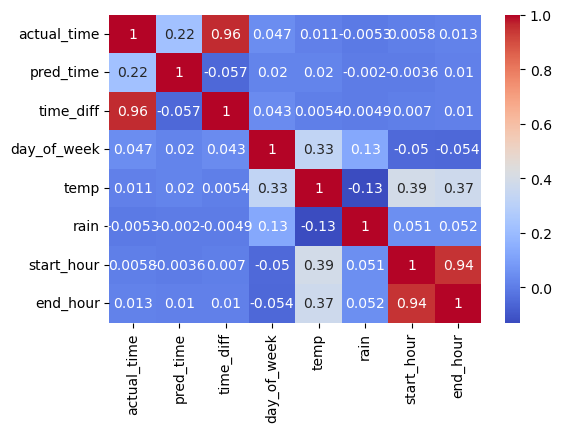

In [43]:
# Create the correlation matrix
trips_cor = df[
    ['actual_time',
    'pred_time',
    'time_diff',
    'start_station_name',
    'end_station_name',
    'day_of_week',
    'temp',
    'rain',
    'rideable_type',
    'member_casual',
    'start_hour',
    'end_hour',
    'quadrant'
    ]
  ]
corrMatrix = trips_cor.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corrMatrix, annot=True, cmap="coolwarm")

In [44]:
df_compareTrip = df.groupby(['rideable_type','member_casual','day_of_week_n'], as_index=False).agg({'actual_time':'mean'})
#df_compareTrip

In [45]:
fig_tripduration = px.sunburst(df_compareTrip, path = ['member_casual', 'rideable_type', 'day_of_week_n'], 
                        values = 'actual_time',
                        color = 'actual_time',
                        color_continuous_scale = 'blues',
                        maxdepth = -1)

fig_tripduration.update_layout(margin = dict(t = 10, b = 10, r = 10, l = 10),
                                showlegend = False,
                                plot_bgcolor = 'black',
                                )
                  
fig_tripduration.show()

fig_tripduration.write_image('member_ridetype_dow.png')
#plt.savefig('member_ridetype_dow.png') #bbox_inches='tight')

AttributeError: type object 'object' has no attribute 'dtype'

In [46]:
#top 100 start routes sunburst chart
fig_tripduration = px.sunburst(top100start, path = ['member_casual', 'start_station_name', 'day_of_week_n'], 
                        values = 'count',
                        color = 'count',
                        color_continuous_scale = 'reds',
                        maxdepth = -1)

fig_tripduration.update_layout(margin = dict(t = 10, b = 10, r = 10, l = 10),
                                showlegend = False,
                                plot_bgcolor = 'black',
                                )
                  
fig_tripduration.show()
fig_tripduration.write_image('member_station_hour.png')

AttributeError: type object 'object' has no attribute 'dtype'

In [47]:
fig_tripduration = px.sunburst(df, path = ['quadrant','start_hour'], 
                        values = 'actual_time',
                        color = 'actual_time',
                        color_continuous_scale = 'blues',
                        maxdepth = -1)

fig_tripduration.update_layout(margin = dict(t = 10, b = 10, r = 10, l = 10),
                                showlegend = False,
                                plot_bgcolor = 'black',
                                )
                  
fig_tripduration.show()

#fig_tripduration.write_image('member_ridetype_dow.png')

AttributeError: type object 'object' has no attribute 'dtype'

In [ ]:
fig_tripduration = px.sunburst(df, path = ['quadrant','start_station_name'], 
                        values = 'actual_time',
                        color = 'actual_time',
                        color_continuous_scale = 'greens',
                        maxdepth = -1)

fig_tripduration.update_layout(margin = dict(t = 10, b = 10, r = 10, l = 10),
                                showlegend = False,
                                plot_bgcolor = 'black',
                                )
                  
fig_tripduration.show()

In [ ]:
fig_tripduration = px.sunburst(df, path = ['quadrant','day_of_week_n'], 
                        values = 'actual_time',
                        color = 'actual_time',
                        color_continuous_scale = 'oranges',
                        maxdepth = -1)

fig_tripduration.update_layout(margin = dict(t = 10, b = 10, r = 10, l = 10),
                                showlegend = False,
                                plot_bgcolor = 'black',
                                )
                  
fig_tripduration.show()

In [ ]:
fig = px.scatter(df, x = 'day_of_week_n', y = 'time_diff', color = 'day_of_week_n', facet_col = 'member_casual', facet_row = 'quadrant', width = 800, height = 1200)
fig.update_layout(title = {"text": "hour vs. time", "x": 0.5,}, title_font_color = 'blue', showlegend = False,) #plot_bgcolor = 'black',
fig.update_xaxes(tickmode = 'auto', showgrid = False) #tickmode = 'linear'
fig.update_yaxes(showgrid = True)
fig.show()

In [ ]:
#hour display count for station below:
sgh = df[df['start_station_name']=='Streeter Dr & Grand Ave'].groupby(df['start_hour']).size().reset_index(name=' Streeter&Grand count')
sgh

In [ ]:
#print(start_route_h_20)

stationhdist = []
main_df = []

for station in df['start_station_name'][0:5]:
    stationhdist.append(df[df['start_station_name']==station].groupby(df['start_hour']).size().reset_index(name='{} hour count'.format(station)))

#stationhdist = pd.DataFrame(stationhdist)
#print(stationhdist)
stationdist = pd.concat(stationhdist)
stationdist[10:30]



In [ ]:
#bucketize lat/longs by quadrant, and by day of week

#quadrant by time of day


In [ ]:
df['quadrant'].value_counts()

In [ ]:
#sns.swarmplot(x="Age", data=df, size = 4.5)

In [ ]:
###wtf won't this run!! lol
#figure, ax = plt.subplots(figsize = (15,5))
#sns.set_palette("Set2")
#sns.swarmplot(x="quadrant", y="actual_time",
             # data=df[0:1000], size = 1.5, ax = ax).set_title('quadrant vs. actual time')

In [ ]:
#folium map for rides
ride_map = folium.Map(location =(41.8781, -87.6298),zoom_start=11)

marker_cluster = MarkerCluster().add_to(ride_map)

for (lat,lng, id) in zip(df['start_lat'][0:1000], df['start_lng'][0:1000], df['ride_id'][0:1000]):
    folium.Marker(location=(lat,lng),popup=
                    folium.Popup(html="lat: %s <br> long: %s<br> ride iD: %s"
                    %(lat,lng, id)),icon=folium.Icon(color='green',
                    icon='ok-sign'),).add_to(marker_cluster)

for (lat,lng, id) in zip(df['end_lat'][0:1000], df['end_lng'][0:1000], df['ride_id'][0:1000]):
    folium.Marker(location=(lat,lng),popup=
                    folium.Popup(html="lat: %s <br> long: %s <br> ride iD: %s"
                    %(lat,lng, id)),icon=folium.Icon(color='red',
                    icon='remove-sign'),).add_to(marker_cluster)

    
ride_map

### modeling

In [ ]:
df.isna().sum()

In [ ]:
dfML = df[['rideable_type', 'member_casual', 'pred_time', 'temp', 'actual_time', 'time_diff', 'quadrant', 'start_hour', 'end_hour', 'day_of_week_n']].copy()
#dfML = df['rideable_type']

In [ ]:
### one hot encoding

rt_dummies = pd.get_dummies(dfML['rideable_type'])
mc_dummies = pd.get_dummies(dfML['member_casual'])
q_dummies = pd.get_dummies(dfML['quadrant'])
wd_dummies = pd.get_dummies(dfML['day_of_week_n'])

#combine and drop originals
dfML = pd.concat([dfML, rt_dummies, mc_dummies, q_dummies, wd_dummies], axis=1)

dfML = dfML.drop(columns = ['rideable_type', 'member_casual', 'quadrant', 'day_of_week_n'])


In [ ]:
dfML.head()

In [ ]:
from sklearn.model_selection import train_test_split
y = dfML['actual_time']
X = dfML.drop(['actual_time'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=30)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
### out of RAM
#clf = RandomForestClassifier(n_estimators = 100, random_state = 20)
#rf_train = clf.fit(X_train,y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
clf.predict_proba(X)[0:5]

In [ ]:
importance = list(zip(X, clf.feature_importances_))
importance

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
accuracy = (metrics.accuracy_score(y_test, y_pred)) * 100
accuracy